In [1]:
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

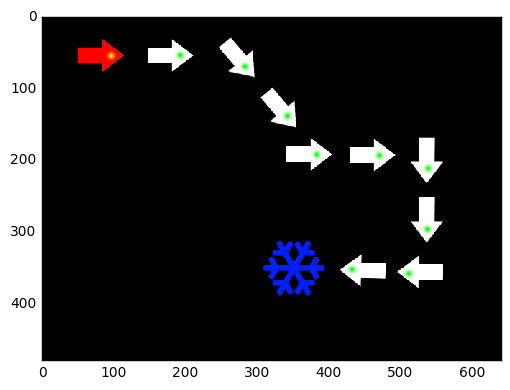

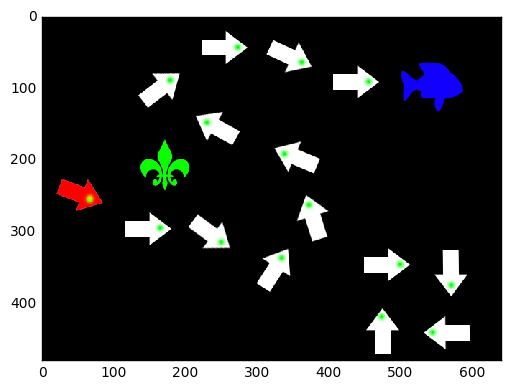

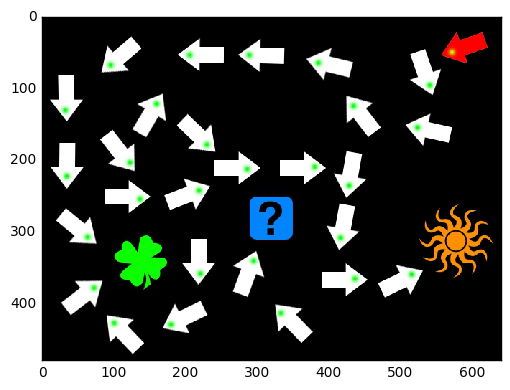

In [2]:
klads = [io.imread('Klad00.jpg'), io.imread('Klad01.jpg'), io.imread('Klad02.jpg')]

def plot_klads(klads):
    for i in klads:
        io.imshow(i)
        io.show()
        
plot_klads(klads)

Порог: 0.04


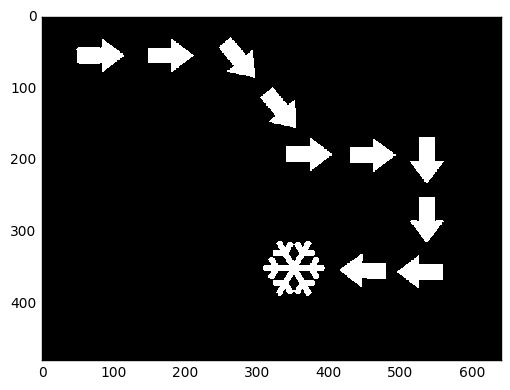

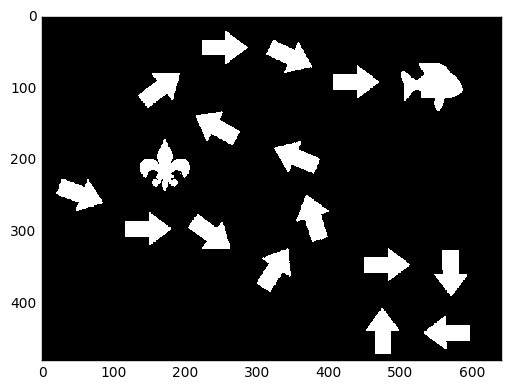

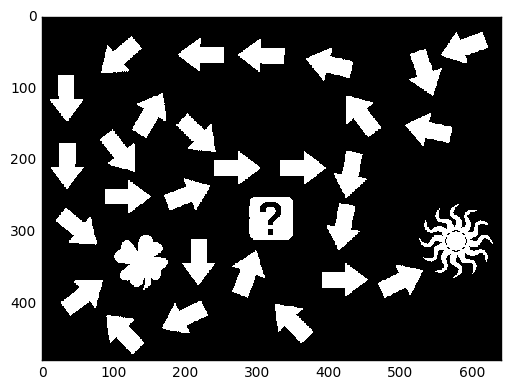

In [3]:
from skimage.color import rgb2gray

thresh = 0.04

def get_binary(img):
    img_gray = rgb2gray(img)
    img_binary = img_gray > thresh
    return img_binary

print u'Порог:', thresh

klads_binary = map(get_binary, klads)
plot_klads(klads_binary)

/home/ilya/.virtualenvs/images/local/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


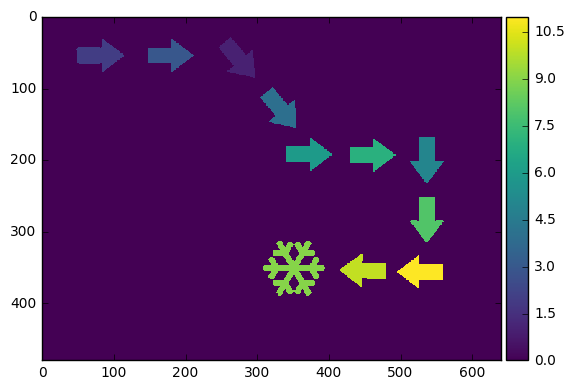

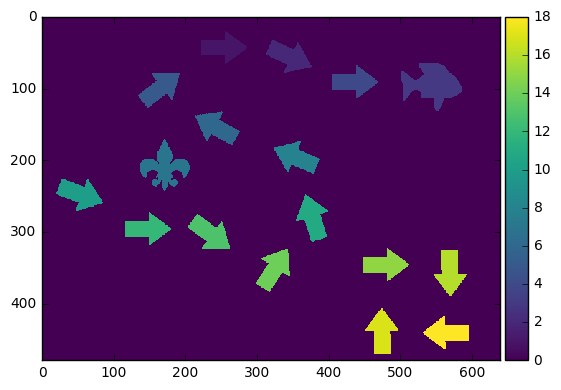

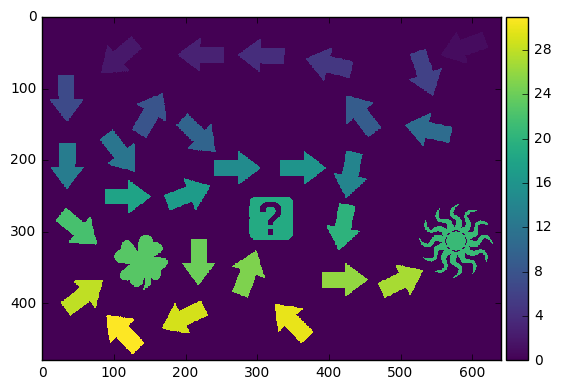

In [4]:
from skimage import measure

def get_connected_components(img):
    components = measure.label(img)
    return components

klad_components = map(get_connected_components, klads_binary)
plot_klads(klad_components)

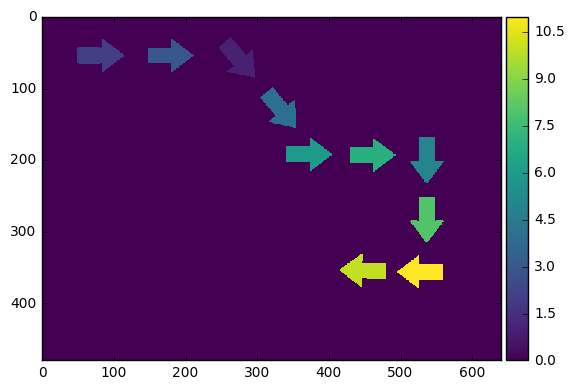

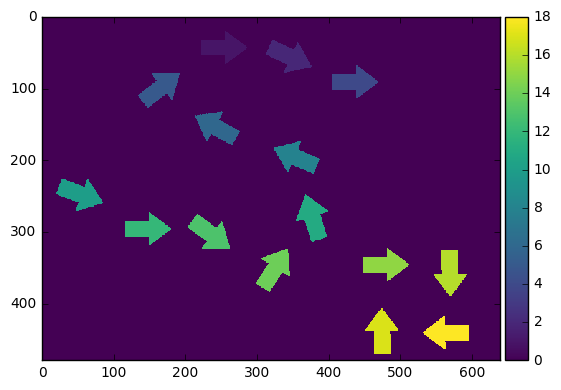

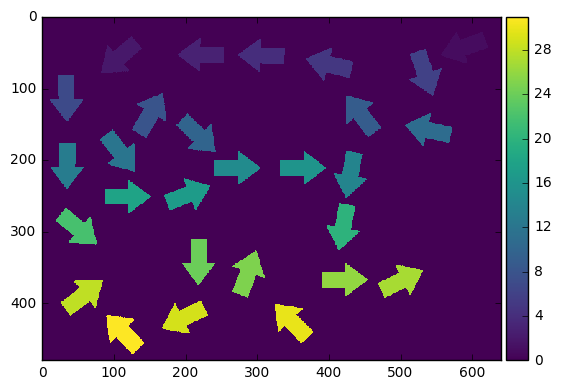

In [5]:
from skimage.measure import regionprops

thresh_eccentricity = 0.8

def get_arrows(components):
    arrows = components.copy()
    labels_props = regionprops(components)
    arrows_labels = [label_props.label 
                   for label_props in labels_props if label_props.eccentricity > thresh_eccentricity]
    for i in range(arrows.shape[0]):
        for j in range(arrows.shape[1]):
            arrows[i][j] = arrows[i][j] in arrows_labels
            
    return arrows * components

klad_arrows = map(get_arrows, klad_components)
plot_klads(klad_arrows)

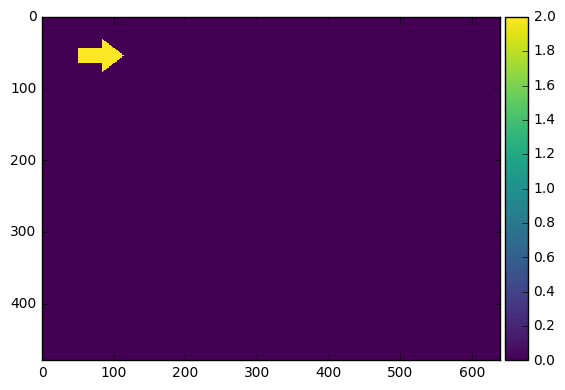

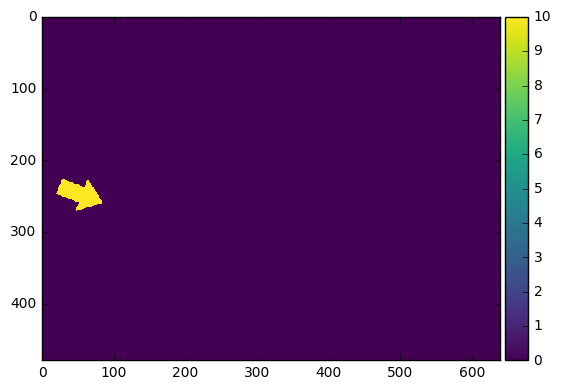

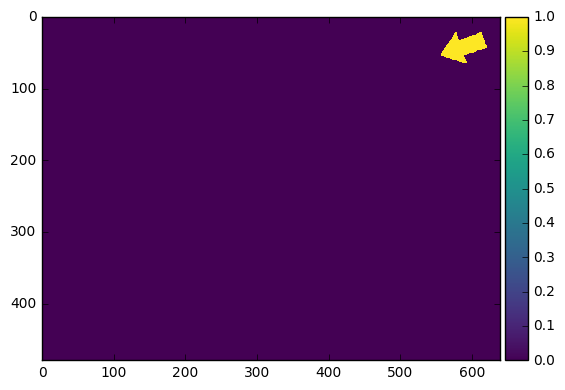

In [6]:
def get_init_arrow((arrows, src)):
    red_mask = (src[:,:,2] < 90) * (src[:,:,0] > 100)
    init_arrow = arrows * red_mask

    return init_arrow

klad_init_arrow = map(get_init_arrow, zip(klad_arrows, klads))
plot_klads(klad_init_arrow)

In [7]:
def get_next_label(label, arrows, src):
    dots = (src[:,:,1] > 50) * (src[:,:,2] < 50) * 100 * (arrows > 0)
    arrows_props = regionprops(arrows, dots + (arrows > 0))
    arrow_props = None
    for p in arrows_props:
        if p.label == label:
            arrow_props = p
            
    cy, cx = arrow_props.centroid
    weighed_cy, weighted_cx = arrow_props.weighted_centroid
    range_x = range(int(weighted_cx), src.shape[1]) if cx < weighted_cx else range(int(weighted_cx), -1, -1)
    def get_y(x):
        return -(weighed_cy - cy) * (weighted_cx - x)/(weighted_cx - cx) + weighed_cy

    next_items = dict()
    next_label = 0.
    for x in range_x:
        y = get_y(x)
        if y < arrows.shape[0] and arrows[y][x] != 0 and arrows[y][x] != label:
            next_label = arrows[y][x]
            next_items[label] = next_label
            break
        
    return next_label

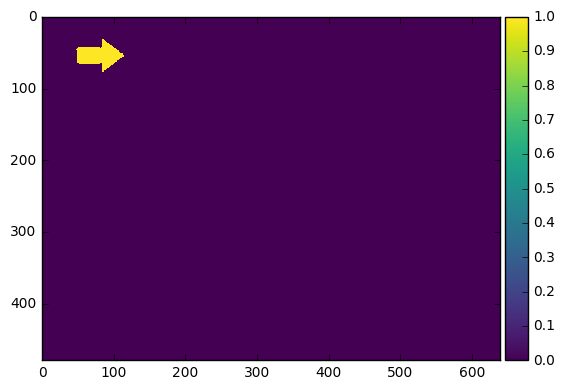

/home/ilya/.virtualenvs/images/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ilya/.virtualenvs/images/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


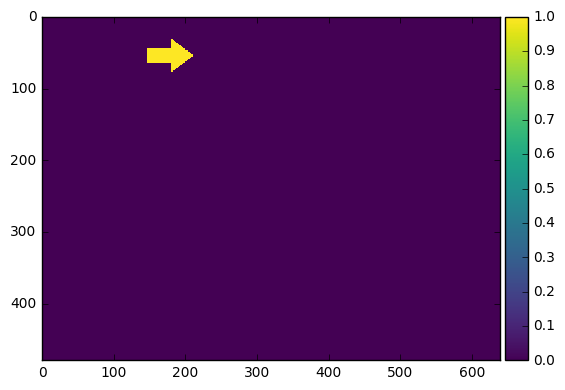

In [8]:
klad0_arrows = klad_arrows[0]
label = 2
io.imshow(klad0_arrows == label)
io.show()
next_label = get_next_label(label, klad0_arrows, klads[0])
io.imshow(klad0_arrows == next_label)
io.show()

In [9]:
import numpy as np

def get_the_treasure(src):
    binary = get_binary(src)
    components = get_connected_components(binary)
    arrows = get_arrows(components)
    arrows_labels = [label_props.label 
                   for label_props in regionprops(components) if label_props.eccentricity > thresh_eccentricity]
    init_arrow = get_init_arrow((arrows, src))
    
    cur_label = (set(init_arrow.ravel()) - {0}).pop()
    while cur_label in arrows_labels:
        cur_label = get_next_label(cur_label, components, src)
    
    return components == cur_label

/home/ilya/.virtualenvs/images/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ilya/.virtualenvs/images/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


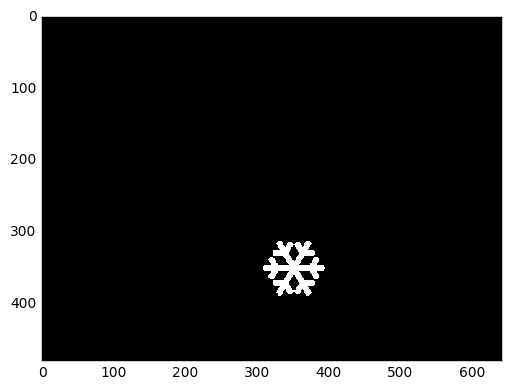

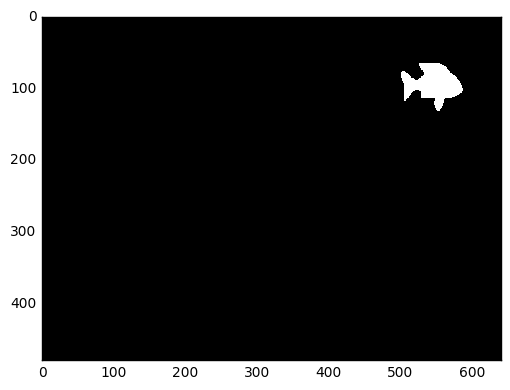

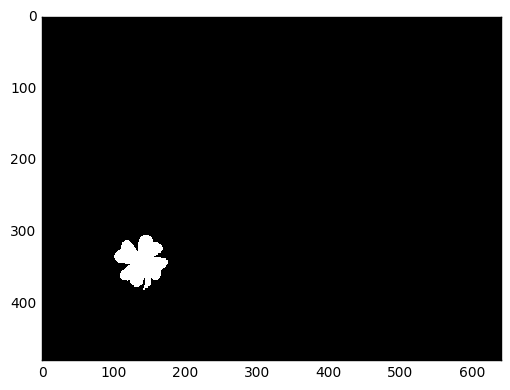

In [10]:
treasures = map(get_the_treasure, klads)
plot_klads(treasures)